# "Pythonizing" a Pipeline for AR Visualization: Proof of Concept

In [31]:
#Load needed libraries
import sys
import os
import logging
from imp import reload

import astropy.units as u
import astropy.constants as const
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('papers')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
import sunpy
from sunpy.net import vso
from solarbextrapolation.map3dclasses import Map3D
from solarbextrapolation.extrapolators import PotentialExtrapolator
import solarbextrapolation.utilities
import yt
from yt.units import cm 

sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src'))
import ebtel_configure as ebc
import ebtel_run as ebr
import em_binner as emb
reload(ebc)
reload(ebr)
reload(emb)

sns.set_context('notebook',font_scale=1.5)
%matplotlib inline

In [32]:
#WARNING: a bit dangerous but astropy is being very noisy
import warnings
warnings.filterwarnings('ignore')

In [35]:
#helper for converting arcseconds to centimeters
#stealing some of this from the solarbextrapolation code
def ang_to_len(ang_or_len,field_map,working_units=u.meter):
    obs_distance = (field_map.dsun - field_map.rsun_meters)
    radian_length = [ (u.radian, u.meter, lambda x: obs_distance * x, lambda x: x / obs_distance) ]
    converted = solarbextrapolation.utilities.decompose_ang_len(ang_or_len,
                                                             working_units=working_units,
                                                             equivalencies=radian_length)
    if working_units == u.meter:
        return converted.to(u.cm)
    else:
        return converted.to(u.arcsec)


In [36]:
#function for calculating streamline seed points from a map and dataset
def find_seed_points_smart(ds,field_map,N=1000,mask_thresh=0.05,safety=1.2,lower_boundary_safety=0.0):
    """
    Mask boundary map above threshold, mark seed points in most polarized spots.
    Would be nice if we could use just ds or just the boundary map, preferably just ds
    """
    
    #mask field data below given threshold
    mask_above_value = mask_thresh*field_map.min()
    masked_data = np.ma.masked_greater(field_map.data,mask_above_value)
    
    #find the ratio of remaining area
    eps_area = float(masked_data.count())/float(field_map.data.shape[0]*field_map.data.shape[1])
    #find the needed length to resample at
    n_resample = int(safety*np.sqrt(N/eps_area))
    
    #resample boundary map
    field_map_resampled = field_map.resample([n_resample,n_resample]*(field_map.xrange/field_map.scale.x).unit,
                                             method='linear')
    #mask resampled map
    resampled_masked_data = np.ma.masked_greater(field_map_resampled.data,mask_above_value)
    #find unmasked positions
    unmasked_indices = [(ix,iy) for iy,ix in zip(*np.where(resampled_masked_data.mask==False))]
    
    #check number of possible indices is greater than requested seed points
    if len(unmasked_indices) < N:
        raise ValueError('Requested number of seed points too large. Increase safety factor.')
    
    #create appropriate x and y arrays to pull from
    x_grid = np.linspace(ang_to_len(field_map_resampled.xrange[0],field_map_resampled).value,
                         ang_to_len(field_map_resampled.xrange[1],field_map_resampled).value,
                         n_resample)
    y_grid = np.linspace(ang_to_len(field_map_resampled.yrange[0],field_map_resampled).value,
                         ang_to_len(field_map_resampled.yrange[1],field_map_resampled).value,
                         n_resample)
    
    #get seed points
    seed_points = []
    while len(seed_points) < N:
        #get a random value
        choice = np.random.randint(0,len(unmasked_indices))
        #append coordinates; note the order of the x and y coordinates here
        seed_points.append([x_grid[unmasked_indices[choice][0]],
                    y_grid[unmasked_indices[choice][1]],
                    ds.domain_left_edge.value[2] + lower_boundary_safety*ds.domain_width.value[2]])
        #remove used index choice
        del unmasked_indices[choice]
        
    #scale to yt units
    seed_points = seed_points*ds.domain_width/ds.domain_width.value
    
    return seed_points


def find_seed_points(ds,N):
    """Find streamline seed points for a given dataset"""
    c = ds.domain_center
    scale = ds.domain_width/5.
    pos_ds = np.random.random((N,3))*scale-scale/2.
    pos = c + pos_ds
    #set z position
    #for p in pos:
    #    p[-1] = ds.domain_left_edge[-1]
    return pos
    

It would be nice to have a way to do AR vizualization all in python. To do this we'll need the ability to do the field line extrapolations, visualize the field lines themselves, map the hydrodynamic simulations to the field lines, and then forward model the intensity.

The workflow might look something like this:

* Query HMI database for relevant magnetogram (using `sunpy`)
* Use `solarbextrapolation` module to do the field extrapolation using PFSS
* Using EBTEL (or HYDRAD), do a hydrodynamic calculation for each of the extrapolated field lines
* Using ChiantiPy, forward model the intensity for a given ion (channel?); once we have improvements here, more accurate and instrument specific forward modeling will be possible.
* Map the intensity back to the extrapolated field lines
* Visualize the AR with `yt`

## Querying an HMI Magnetogram

First, create a new client and add filters for collecting the desired data. This part of the notebook follows exactly from the [sample `solarbrextrapolation` notebook courtesy of SunPy and Alex Hamilton](https://github.com/sunpy/solarbextrapolation).

In [37]:
#set these to none if you want to do the query again; if you want a different AR, you'll have to requery of course
hmi_data_file = '/home/wtb2/sunpy/data/hmi_m_45s_2013_01_01_08_58_30_tai_magnetogram.fits'
aia_data_file = '/home/wtb2/sunpy/data/aia_lev1_94a_2013_01_01t07_34_01_12z_image_lev1.fits'

In [38]:
client = vso.VSOClient()

In [39]:
result_hmi = client.query(
    vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)),
    vso.attrs.Instrument('HMI'),
    vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
    vso.attrs.Sample(5000 * u.s)  
)

Save the query using FITS files.

In [40]:
#warning! don't query this again, takes a long time; check for file first
if hmi_data_file is None:
    data_hmi = client.get(result_hmi, methods=('URL-FILE_Rice', 'URL-FILE')).wait()
else:
    data_hmi = [hmi_data_file]

Next, let's grab the corresponding AIA data.

In [41]:
result_aia = client.query(
    vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)), # Time range.
    vso.attrs.Instrument('AIA'),
    vso.attrs.Physobs('intensity'), 
    vso.attrs.Sample(5000 * u.s)    
)

In [42]:
#warning! don't query this again, takes a long time; check for file first
if aia_data_file is None:
    data_aia = client.get(result_aia, methods=('URL-FILE_Rice', 'URL-FILE')).wait()
else:
    data_aia = [aia_data_file]

Peek at both of the resulting maps to see what the results look like.

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


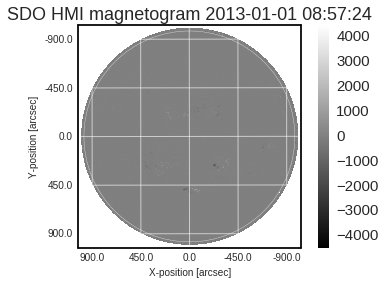

In [43]:
hmi_map = sunpy.map.Map(data_hmi[0])
hmi_map.peek()
hmi_map.draw_limb()

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


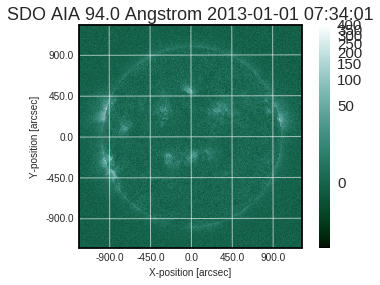

In [44]:
aia_map = sunpy.map.Map(data_aia[0])
aia_map.peek()

## Cropping and Resampling

There seem to be some issues cropping and then resampling. What if we resample and then crop? Crop and then resample? Both seem to cause sign of axes to be reversed. Currently [an open issue](https://github.com/sunpy/sunpy/issues/1855#issuecomment-235720350) regarding this.

What if we rotate the map first?

In [45]:
hmi_map = hmi_map.rotate()

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


Next, let's create a submap around the region of interest. We need to crop both images around the active region.

In [46]:
xrange = u.Quantity([-140,90] * u.arcsec)
yrange = u.Quantity([420,560] * u.arcsec)
zrange = u.Quantity([0,150] * u.arcsec) #maybe this should be set to something more "sensible"
zshape = 50

In [47]:
hmi_map_cropped = hmi_map.submap(xrange,yrange)

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


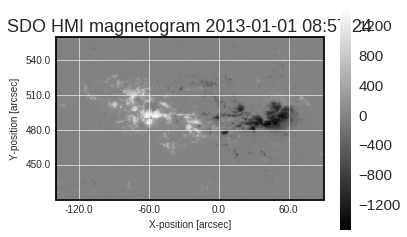

In [48]:
hmi_map_cropped.peek()

Now, resample (or do not...)

In [49]:
shape = u.Quantity([100,100] * u.pixel)
hmi_map_cropped_resampled = hmi_map_cropped.resample(shape, method='linear')

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


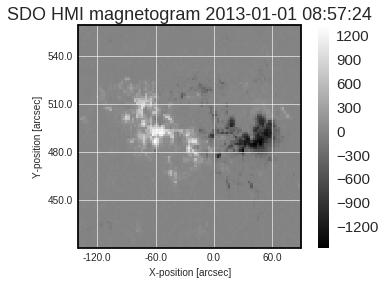

In [50]:
hmi_map_cropped_resampled.peek()

Now, let's crop the AIA map over the same ROI.

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


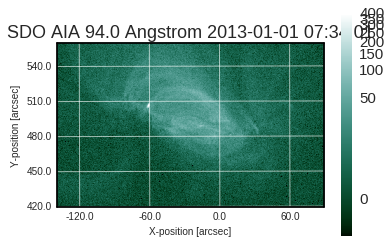

In [51]:
aia_map_cropped = aia_map.submap(xrange,yrange)
aia_map_cropped.peek()

## Field Extrapolation
Notice that we really only need one piece of information going into this part of the calculation: the LOS magnetogram.

Now that we have the relevant boundary data, we want to perform the field extrapolation with PFSS. ~~We'll convert the map from angular to length coordinates before passing it to the extrapolator.~~

In [52]:
aPotExt = PotentialExtrapolator(hmi_map_cropped_resampled,
                                zshape=zshape,
                                zrange=zrange
                               )

In [53]:
aMap3D = aPotExt.extrapolate(enable_numba=True)

True


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/numba/decorators.py:24: DeprecationWarning: autojit is deprecated, use jit instead which now performs the same functionality
  "the same functionality", DeprecationWarning)


## Field Line Visualization with `yt`
Now, as a preliminary step, we want to visualize the field lines from the PFSS field extrapolation. 

We need to reshape the data into something `yt` can load. We're going to strip the first and last 2 rows in each case. This is because some "padding" needs to be added to the volume in order to perform the differentiation in the extrapolation routine. We will adjust the bounds appropriately as well to avoid mishaping the field.

In [54]:
tmp_cropped_data = aMap3D.data[2:-2,2:-2,2:-2,:]
data = dict(
    Bx=(np.swapaxes(tmp_cropped_data[:,:,:,1],0,1),"T"),
    By=(np.swapaxes(tmp_cropped_data[:,:,:,0],0,1),"T"),
    Bz=(np.swapaxes(tmp_cropped_data[:,:,:,2],0,1),"T")
)

We also want to crop the boundary layer appropriately. Hopefully the upstream `solarbextrapolation` code will change so that all of these hacks won't be needed in the future.

In [55]:
boundary_map = hmi_map_cropped_resampled.submap(
    hmi_map_cropped_resampled.xrange+hmi_map_cropped_resampled.scale.x*u.Quantity([2.*u.pixel,-2.*u.pixel]),
    hmi_map_cropped_resampled.yrange+hmi_map_cropped_resampled.scale.y*u.Quantity([2.*u.pixel,-2.*u.pixel])
)

To convert from angular to length units, use the `_angle_to_length()` method of the `Extrapolator` class  in `solarbextrapolation`

In [56]:
bbox = np.array([ang_to_len(boundary_map.xrange,boundary_map).value,
                 ang_to_len(boundary_map.yrange,boundary_map).value,
                 ang_to_len(aMap3D.zrange+aMap3D.scale.z*u.Quantity([2.*u.pixel,-2.*u.pixel]),boundary_map).value])

In [57]:
ds = yt.load_uniform_grid(data,
                          data['Bx'][0].shape,
                          bbox=bbox,
                          length_unit='cm',
                          geometry=('cartesian',('x','y','z')),
                          nprocs=64)

yt : [INFO     ] 2016-08-30 14:26:03,246 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-08-30 14:26:03,246 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2016-08-30 14:26:03,247 Parameters: domain_left_edge          = [ -9.60457113e+09   3.00299772e+10   4.25943005e+08]
yt : [INFO     ] 2016-08-30 14:26:03,248 Parameters: domain_right_edge         = [  6.06528458e+09   3.95487272e+10   1.02226321e+10]
yt : [INFO     ] 2016-08-30 14:26:03,249 Parameters: cosmological_simulation   = 0.0


Find the appropriate seed points. These are chosen so that they lie only in regions of the map with negative polarity. Another approach is just to randomly sample the _entire_ domain with lots of points and then filter appropriately. We can be a bit smarter though.

In [58]:
N=250
seed_points = find_seed_points_smart(ds,boundary_map,N=N,mask_thresh=0.1,lower_boundary_safety=0.0)
streamlines = yt.visualization.api.Streamlines(ds,
                                               seed_points,
                                               xfield='Bx',yfield='By',zfield='Bz',
                                               get_magnitude=True,direction=-1,
                                               #length=2.*ds.domain_width[-1].value*cm
                                            )
streamlines.integrate_through_volume()
streamlines.clean_streamlines()

yt : [INFO     ] 2016-08-30 14:26:11,952 AMRKDTree rebuilt, Final Volume: 1.461249e+30
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 306.19it/s]


Test the seed points.

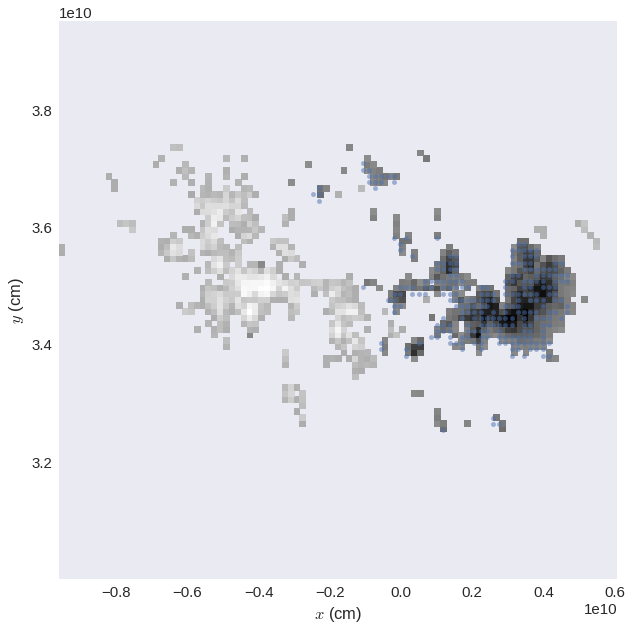

In [59]:
#add magnetogram surface
#plot the bottom most slice of ds in Bz on top
X,Y = np.meshgrid(
        np.linspace(ang_to_len(boundary_map.xrange,boundary_map).value[0],
                    ang_to_len(boundary_map.xrange,boundary_map).value[1],
                    boundary_map.dimensions.x.value),
        np.linspace(ang_to_len(boundary_map.yrange,boundary_map).value[0],
                    ang_to_len(boundary_map.yrange,boundary_map).value[1],
                    boundary_map.dimensions.y.value),
)
mg_masked = np.ma.array(boundary_map.data,
                        mask=np.fabs(boundary_map.data)<np.max(np.fabs(boundary_map.data))*0.1
                       )
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.pcolor(X,Y,mg_masked,cmap=plt.cm.Greys_r)
for sp in seed_points:
    ax.scatter(sp[0].value,sp[1].value,color=sns.color_palette('deep')[0],alpha=0.5)
ax.set_xlim(ang_to_len(boundary_map.xrange,boundary_map).value)
ax.set_ylim(ang_to_len(boundary_map.yrange,boundary_map).value)
ax.set_xlabel(r'$x$ (cm)')
ax.set_ylabel(r'$y$ (cm)')
plt.show()

Plot the fieldlines in 3D.

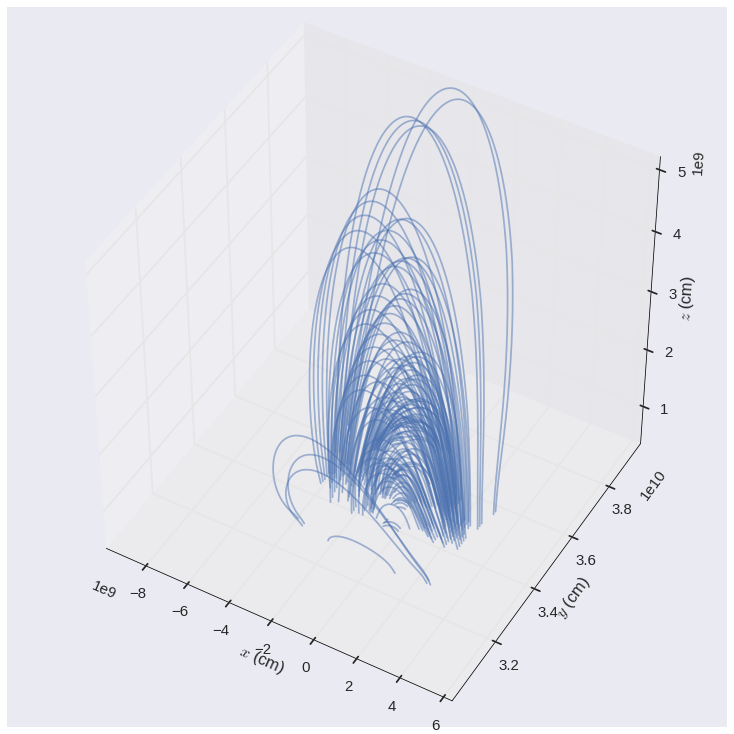

In [60]:
#plot fieldlines in AR
fig=plt.figure(figsize=(10,10))
ax = Axes3D(fig)
#add fieldlines
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    if np.fabs(stream[0,2] - stream[-1,2]) < 0.05*ds.domain_width[2]:
        ax.plot3D(stream[:,0], stream[:,1], stream[:,2], alpha=0.5,color=sns.color_palette('deep')[0])
#axes options
ax.set_xlim([ds.domain_left_edge.value[0],ds.domain_right_edge.value[0]])
ax.set_ylim([ds.domain_left_edge.value[1],ds.domain_right_edge.value[1]])
ax.set_zlim([ds.domain_left_edge.value[2],0.5*ds.domain_right_edge.value[2]])
ax.view_init(elev=45, azim=300)
ax.set_xlabel(r'$x$ (cm)')
ax.set_ylabel(r'$y$ (cm)')
ax.set_zlabel(r'$z$ (cm)')
#plt.colorbar(mg_bound)

We can do a bit better when only showing the 2D picture by letting WCSAxes do all of the work for us. Here, we can also how we can nicely overplot the fieldlines on top of the original HMI image.

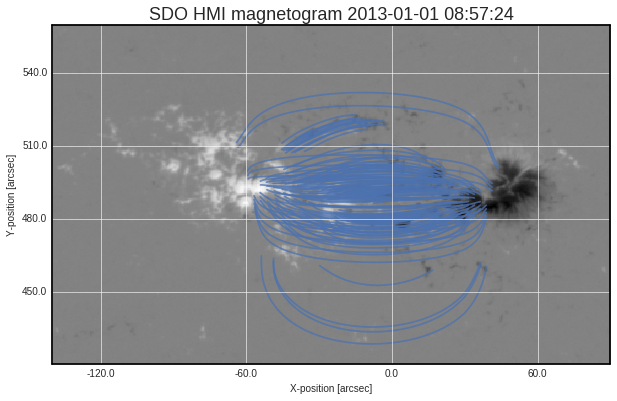

In [61]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=hmi_map_cropped)
hmi_map_cropped.plot(axes=ax)
#ax.scatter((0.*u.arcsec).to(u.deg),(510.*u.arcsec).to(u.deg),
#           c='r',s=50,transform=ax.get_transform('world'))
ax.set_autoscale_on(False)
for stream,mag in zip(streamlines.streamlines,streamlines.magnitudes):
    stream = stream[np.all(stream != 0.0, axis=1)]
    mag = mag[np.all(stream != 0.0, axis=1)]
    if np.fabs(stream[0,2] - stream[-1,2]) < 0.05*ds.domain_width[2]:
        ax.plot(ang_to_len(stream[:,0]*u.cm,boundary_map,working_units=u.arcsec).to(u.deg),
                ang_to_len(stream[:,1]*u.cm,boundary_map,working_units=u.arcsec).to(u.deg),
                alpha=0.75,color=sns.color_palette('deep')[0],transform=ax.get_transform('world'))
plt.show()

## Loop Data Cleaning

Now we want to get the loop data (i.e. loop length, $(x,y,z)$ coordinates, $s$ coordinates, We probably don't want to keep any loops with full lengths $L<10$ Mm or $L>500$ Mm. Need a loop filter function that takes out any open field lines as well as loops that don't fall in the requested range. We want a reasonably "clean" active region. 

We apply to filtering criteria to the loops:

* $20<L<500$ Mm to avoid overly long and really short loops
* $|z(s=0) - z(s=L)| < \epsilon\Delta Z$, field lines must close

In [75]:
active_region_loops = []
loop_length_range = [2.e+9,5.e+10]
for stream,bmag,i in zip(streamlines.streamlines,streamlines.magnitudes,range(len(streamlines.streamlines))):
    stream = stream[np.all(stream != 0.0, axis=1)]
    #check if open field line
    if np.fabs(stream[0,2] - stream[-1,2]) > 0.05*ds.domain_width[2]:
        #print('Skipping open field line')
        continue
    #calculate loop length
    loop_length = np.sum(np.linalg.norm(np.diff(stream,axis=0),axis=1))
    #check if in desired range
    if loop_length < loop_length_range[0] or loop_length > loop_length_range[1]:
        #print('Skipping too long or too short loop')
        continue
    #store other properties if we passed all of the tests
    active_region_loops.append({'name':'loop_%d'%(i),
                                'loop_length':loop_length,
                                'xyz':np.array(stream),
                                'B_mag':(np.array(bmag)*u.T).to(u.Gauss).value,
                                's':np.append(0.,np.linalg.norm(np.diff(stream,axis=0),axis=1).cumsum())
                               }
                              )

Now, check the distribution of loop lengths.

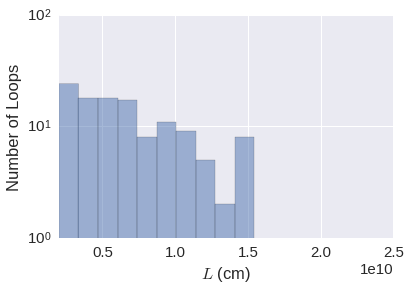

In [76]:
fig = plt.figure()
ax = fig.gca()
ax.hist(np.array([arl['loop_length'] for arl in active_region_loops]),
        bins=10,
        alpha=0.5,
        log=True,
        color=sns.color_palette('deep')[0]
       )
ax.set_ylabel(r'Number of Loops')
ax.set_xlabel(r'$L$ (cm)')
#ax.set_xscale('log')
ax.set_xlim([2e+9,2.5e+10])
plt.show()

## EBTEL Input Files
Now, for each active region loop, we need to prepare an EBTEL input file. The two things that matter are the loop length (the half-length in Mm) and the magnetic field strength. From [Reep et al. (2013)](), we can estimate the amount of free magnetic energy as,
$$
E_B = \frac{(\epsilon\bar{B})^2}{8\pi}.
$$
We can interpret this as the total amount of energy available to be injected into the loop. Then, we can set $H_{eq}=E_B/t_{total}$ in the EBTEL constrainer routine.

First, set the base dictionary needed to configure an EBTEL run.

In [84]:
#input dictionary
config_dict = {'usage_option':'no_dem',
               'rad_option':'rk',
               'dem_option':'new',
               'heat_flux_option':'classical',
               'solver':'rka4',
               'ic_mode':'st_eq',
               'print_plasma_params':'True'
              }
config_dict['total_time'] = 5000.
config_dict['tau'] = 0.01
config_dict['rka_error'] = 1.0e-5
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'file'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = -1.5
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
#variable c1 options
config_dict['r3_cond_0'] = 6.0
config_dict['r3_rad_0'] = 0.6
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_grav_correction'] = 'True'

Then, set the heating frequency and calculate the number of events.

In [85]:
tn = 750.0
config_dict['num_events'] = int(np.ceil(config_dict['total_time']/(tn + 2.*config_dict['t_pulse_half'])))

Next, configure some directories to put all of the results and config files in.

In [86]:
top_results_dir = os.path.join('/data/datadrive2/ar_viz',
                               '_'.join(hmi_map.meta['telescop'].split('/'))+'_'+hmi_map.meta['date-obs'])
if not os.path.exists(os.path.join(top_results_dir,'data')):
    os.makedirs(os.path.join(top_results_dir,'data'))
if not os.path.exists(os.path.join(top_results_dir,'config')):
    os.makedirs(os.path.join(top_results_dir,'config'))

We need a function to calculate the available free magnetic energy from the field. 

In [87]:
def calc_free_energy(s,b_field,stress_level=0.3):
    b_field_avg = np.average(b_field,weights=np.gradient(s))
    return ((stress_level*b_field_avg)**2)/(8.*np.pi)

Finally, we'll build the all of the EBTEL configuration files that we need.

In [88]:
ebtel_configurer = ebc.Configurer(config_dict,'',t_wait_q_scaling=1.0,delta_q=100)

In [89]:
#for quick plotting, save the inter-event periods and heating rates.
inter_event_periods = []
heating_rates = []

In [90]:
for loop in active_region_loops:
    config_dict['loop_length'] = (loop['loop_length']/1.e+8)/2.
    config_dict['output_file'] = os.path.join(top_results_dir,'data',loop['name'])
    ebtel_configurer.Hn = calc_free_energy(loop['s'],loop['B_mag'])/config_dict['total_time']
    ebtel_configurer.amp_arrays(tn)
    ebtel_configurer.time_arrays(tn)
    ebtel_configurer.print_xml_config(config_file=os.path.join(top_results_dir,'config',loop['name']+'.xml'))
    inter_event_periods.extend((np.diff(ebtel_configurer.config_dictionary['start_time_array'])-2.*ebtel_configurer.config_dictionary['t_pulse_half']))
    heating_rates.extend(ebtel_configurer.config_dictionary['amp_array'])

Print a job configuration file that will make the PBS runs easier to start.

In [91]:
executable = os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_C/bin/ebtel')
f = open(os.path.join(top_results_dir,'job_array.config'),'w')
for loop in active_region_loops:
    f.write('%s\t'%(executable))
    f.write('%s\n'%(os.path.join(top_results_dir,'config',loop['name']+'.xml')))
f.close()

In [93]:
len(active_region_loops)

120

## EBTEL Results
First, let's look at the distribution of heating rates and inter-event periods.

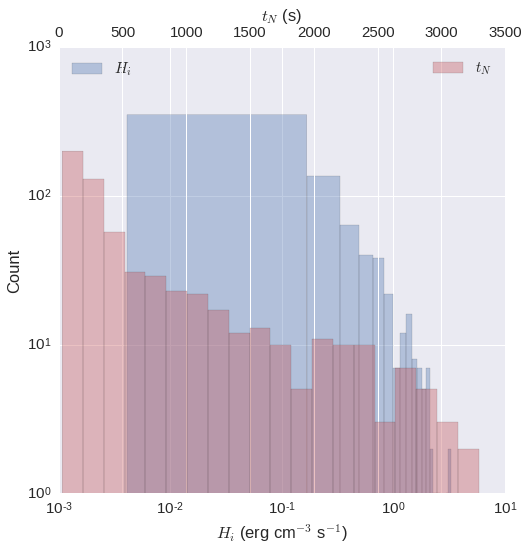

In [96]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax_top = ax.twiny()
_ = ax_top.hist(inter_event_periods,bins=20,color=sns.color_palette('deep')[2],alpha=0.35,label=r'$t_N$')
_ = ax.hist(heating_rates,bins=20,color=sns.color_palette('deep')[0],alpha=0.35,label=r'$H_i$')
ax.set_xlabel(r'$H_i$ (erg cm$^{-3}$ s$^{-1}$)')
ax_top.set_xlabel(r'$t_N$ (s)')
ax.set_ylabel(r'Count')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax_top.legend(loc=1)

Let's take a look at the EBTEL results quickly just to make sure everything ran alright. 

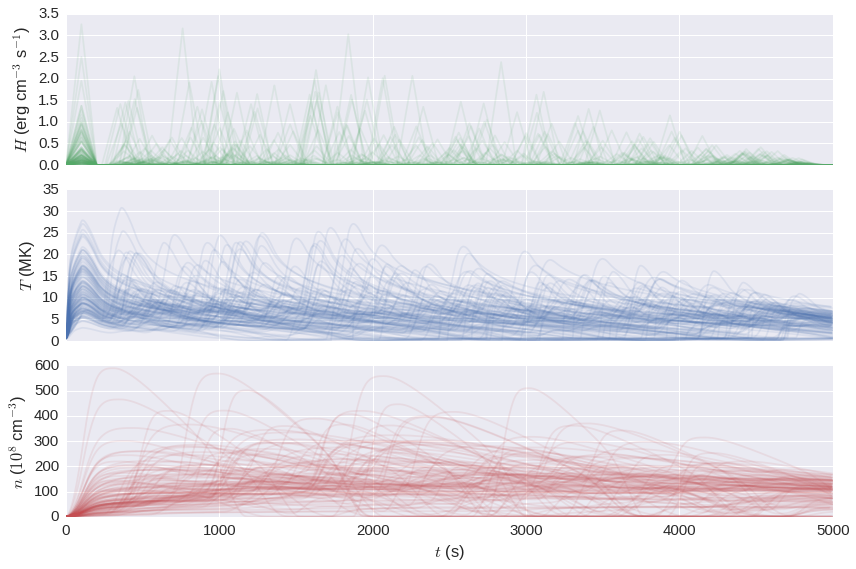

In [97]:
#Warning! This takes several minutes! Better to skip it...
fig,axes = plt.subplots(3,1,figsize=(12,8),sharex=True)
for loop in active_region_loops:
    data = np.loadtxt(os.path.join(top_results_dir,'data',loop['name']+'.txt'))
    time,temperature,density,heat = data[:,0],data[:,1],data[:,2],data[:,-4]
    axes[0].plot(time,heat,color=sns.color_palette('deep')[1],alpha=0.1)
    axes[1].plot(time,temperature/1e+6,color=sns.color_palette('deep')[0],alpha=0.1)
    axes[2].plot(time,density/1e+8,color=sns.color_palette('deep')[2],alpha=0.1)
axes[2].set_xlabel(r'$t$ (s)')
axes[0].set_ylabel(r'$H$ (erg cm$^{-3}$ s$^{-1}$)')
axes[1].set_ylabel(r'$T$ (MK)')
axes[2].set_ylabel(r'$n$ ($10^8$ cm$^{-3}$)')
axes[2].set_xlim([0,config_dict['total_time']])
plt.tight_layout()

## AIA Temperature Response Functions
In preparation for the next section, let's grab the AIA response functions for the 6 EUV channels (excluding 304 $\mathrm{\mathring{A}}$). For now, these are just read in from a file that was created by calling the appropriate function in SSW in IDL. Soon however, these will be available from SunPy so we won't even need to have to read these from a prepared file.

In [98]:
channels = ['94','131','171','193','211','335'] #the order here is unfortunately important
channel_colors = {'94':'red','131':'royal blue','171':'yellow','193':'bright green','211':'hot pink','335':'cyan'}
aia_response_functions = {}
data = np.loadtxt('aia_tresponse_raw.dat')
#get temperature array
aia_response_functions['temperature'] = 10**data[:,0]
for c in channels:
    aia_response_functions[c] = data[:,channels.index(c)+1]

Let's take a quick look at these.

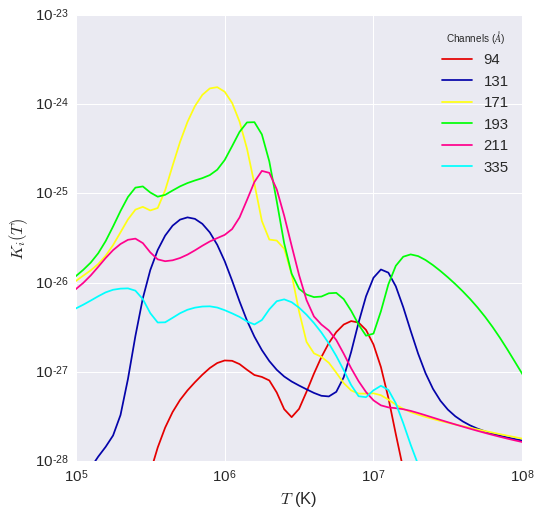

In [99]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for c in channels:
    ax.plot(aia_response_functions['temperature'],
            aia_response_functions[c],color=sns.xkcd_rgb[channel_colors[c]],
            label=r'%s'%(c))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$K_i(T)$')
ax.set_xlim([1e5,1e8])
ax.set_ylim([1e-28,1e-23])
ax.legend(loc='best',title=r'Channels ($\AA$)')

## Calculating Emission
Now that we've done the simulations and have the loop lengths, we need to calculate the emission coming from these loops. From the First, we'll need to calculate the volumetric differential emission measure $\mathrm{DEM}(T)=n^2\mathrm{d}V/\mathrm{d}T$ for each loop at each timestep. From Boerner et al. (2012), we know that
$$
p_i(\bar{x}) = \int\mathrm{d}T\,K_i(T)\mathrm{DEM}(\bar{x},T)
$$
but this has units of DN cm$^{2}$ pixel$^{-1}$ s$^{-1}$ and we still need to project down onto the $(x,y)$ plane. Thus, our modified expression is
$$
p^{*}_i(\bar{x}) = \frac{1}{dA_{pix}}\int\mathrm{d}z\,p_i(\bar{x}),
$$
where $A_{pix}$ is the pixel area in $cm^{2}$ and $d$ is the distance from the satellite to the emitting volume.

First, gather the EBTEL output data into our loop length data structure. Here, we will assume these loops have a constant cross-sectional area of $A_{cs}=10^{14}$ cm$^{2}$ and that $\mathrm{d}V=LA_{cs}/N_s$, where $N_s$ is the number of grid points.

Now, we need to calculate the first integral. With EBTEL, the plasma parameters are uniform across the loop so we can map the same $p_i(\bar{x})$ value to each point along the loop. Thus, we need only calculate $p$ for each channel as a function of time $t$ for each loop in the active region. This value is then mapped to each coordinate $(x,y,z)$ along the loop length. 

__NOTE__: In the final product, many of these steps can be combined. We show them separately for clarity.

Finally, we need to interpolate the time dependent emission in each channel for each loop so that the intensity values in each loop are concurrent.

In [100]:
cross_sectional_area = 1.0e+14
response_interpolated = {key:None for key in aia_response_functions if key != 'temperature'}
universal_time = np.arange(0,config_dict['total_time'],1)
binner = emb.EM_Binner(loop['loop_length'])
for loop in active_region_loops:
    data = np.loadtxt(os.path.join(top_results_dir,'data',loop['name']+'.txt'))
    time,temperature,density = data[:,0],data[:,1],data[:,2]
    binner.set_data(time,temperature,density)
    binner.dVolume=loop['loop_length']*cross_sectional_area/float(len(loop['s']))
    binner.build_em_dist(build_mat=True)
    dem = binner.dem_mat
    t_dem = binner.T_em
    pdv = {}
    for key in aia_response_functions:
        if key != 'temperature':
            if response_interpolated[key] is None:
                response_interpolated[key] = np.interp(t_dem,aia_response_functions['temperature'],aia_response_functions[key])
            pdv[key] = np.trapz(dem*response_interpolated[key],t_dem)
            pdv[key] = np.interp(universal_time,time,pdv[key])
    loop['pdv'] = pdv

## Loading Loops Back into 3D Coordinates
We now have the emission in each AIA channel for each loop as a function of time. Now, we need to find some way to map this back to our 3D loop system.

It would be nice to have a more elegant solution using `yt` at some point, but for now we will just use a 2D histogram to rebin the data at AIA resolution using the appropriate weights. This will first involve reshaping and flattening all of the data so that we can feed it to the 2D histogram.

In [101]:
x_coords,y_coords = [],[]
intensities = {c:len(universal_time)*[None] for c in channels}

In [102]:
for loop in active_region_loops:
    x_coords.extend(loop['xyz'][:,0])
    y_coords.extend(loop['xyz'][:,1])
    for key in intensities:
        for i in range(len(intensities[key])):
            if intensities[key][i] is None:
                intensities[key][i] = len(loop['xyz'])*[loop['pdv'][key][i]]
            else:
                intensities[key][i] += len(loop['xyz'])*[loop['pdv'][key][i]]

Set the number of bins and bin edges based on the original HMI and AIA maps. Remember that we want the map to be at AIA resolution.

In [103]:
bin_ranges = [ang_to_len(boundary_map.xrange,boundary_map).value,
              ang_to_len(boundary_map.yrange,boundary_map).value]
bins = [int(boundary_map.dimensions.x.value),int(boundary_map.dimensions.y.value)]

We want to weight every entry by $\mathrm{d}z/d/A_{pix}$.

In [104]:
dz = ds.domain_width.value[2]/(zshape-4)
a_pixel = (ang_to_len(1.0*u.pixel*aia_map_cropped.scale.x,aia_map_cropped)*ang_to_len(1.0*u.pixel*aia_map_cropped.scale.y,aia_map_cropped)).value
uniform_weight = dz/boundary_map.dsun.value/a_pixel

Finally, build the histogram, using the intensity values as weights.

In [105]:
data,XE,YE = np.histogram2d(x_coords,y_coords,bins=bins,range=bin_ranges,weights=uniform_weight*np.array(intensities['94'][0]))

## SunPy Maps
Now, we want to ultimately use SunPy Maps to visualize our active regions. We need to provide both a Map header as well as the data.

We need to reset the shape in the map header. When we resample at AIA resolution, this problem will be solved.

In [106]:
new_header = aia_map_cropped.meta.copy()

In [107]:
new_header['crpix1'] = boundary_map.meta['crpix1']
new_header['crpix2'] = boundary_map.meta['crpix2']
new_header['crval1'] = boundary_map.meta['crval1']
new_header['crval2'] = boundary_map.meta['crval2']
new_header['cdelt1'] = boundary_map.meta['cdelt1']
new_header['cdelt2'] = boundary_map.meta['cdelt2']
new_header['naxis1'] = bins[0]
new_header['naxis2'] = bins[1]
new_header['datavals'] = np.shape(data)[0]*np.shape(data)[1]

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


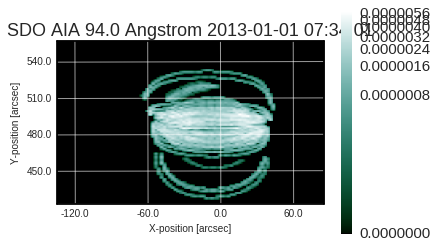

In [108]:
test_map = sunpy.map.Map(data.T,new_header)
test_map.resample(u.Quantity([((boundary_map.xrange[1]-boundary_map.xrange[0])/aia_map.scale.x).value,
                  ((boundary_map.yrange[1]-boundary_map.yrange[0])/aia_map.scale.y).value])*u.pixel).peek()

## Animating AR Evolution
Now, we want to animate the active region evolution using the SunPy MapCube object. The best way to do this is probably to save a set of fits files for each channel once the maps are resampled appropriately. Then, we can call MapCube on the directory of fits files.

First, set the correct AIA resolution to resample the maps at:

In [109]:
aia_res = u.Quantity([((boundary_map.xrange[1]-boundary_map.xrange[0])/aia_map.scale.x).value,
                  ((boundary_map.yrange[1]-boundary_map.yrange[0])/aia_map.scale.y).value])*u.pixel

Now, print the maps to fits files for later.

In [110]:
fits_dir = '/data/datadrive2/ar_viz/SDO_HMI_2013-01-01T08:57:24.20/aia_channel%s_fits'
fits_file = 'aia%s_t%d.fits'

In [ ]:
delta_t_index = 1
for key in intensities:
    #check for existence of directory
    if not os.path.exists(fits_dir%(key)):
        os.makedirs(fits_dir%(key))
    #update the channel in the header
    new_header['wavelnth'] = int(key)
    for i in range(0,len(universal_time),delta_t_index):
        #make the histogram
        data,_,_ = np.histogram2d(x_coords,
                                    y_coords,
                                    bins=bins,
                                    range=bin_ranges,
                                    weights=uniform_weight*np.array(intensities[key][i]))
        #update the timestamp
        new_header['t_obs'] = universal_time[i]
        #make the sunpy map and resample at the right resolution
        sunpy_map = sunpy.map.Map(data.T,new_header).resample(aia_res)
        #save the map to a FITS file
        sunpy_map.save(os.path.join(fits_dir%(key),fits_file%(key,i)))

Make sure the files are in the right order.

In [ ]:
fits_files_ordered = {key:None for key in intensities}
for key in fits_files_ordered:
    fits_files_ordered[key] = [os.path.join(fits_dir%(key),bare_file) for bare_file in sorted([f for f in os.listdir(fits_dir%(key)) if f[0] != '.'],
                           key=lambda x: int(x.split('_')[-1].split('.')[0][1:]))]

### 94 Angstrom Channel

In [ ]:
HTML(sunpy.map.Map(fits_files_ordered['94'],cube=True).peek(vmin=1e-5,vmax=0.01).get_animation().to_html5_video())

### 193 Angstrom Channel

In [ ]:
HTML(sunpy.map.Map(fits_files_ordered['193'],cube=True).peek(vmin=1e-5,vmax=10).get_animation().to_html5_video())

### 171 Angstrom Channel

In [ ]:
HTML(sunpy.map.Map(fits_files_ordered['171'],cube=True).peek(vmin=1e-5,vmax=10).get_animation().to_html5_video())

### 211 Angstrom Channel

In [ ]:
HTML(sunpy.map.Map(fits_files_ordered['211'],cube=True).peek(vmin=1e-5,vmax=10).get_animation().to_html5_video())

### 131 Angstrom Channel

In [ ]:
HTML(sunpy.map.Map(fits_files_ordered['131'],cube=True).peek(vmin=1e-5,vmax=10).get_animation().to_html5_video())

### 335 Angstrom Channel

In [ ]:
HTML(sunpy.map.Map(fits_files_ordered['335'],cube=True).peek(vmin=1e-5,vmax=10).get_animation().to_html5_video())